In [221]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import joblib
import os
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# ---------------------------
# 1. Load and Preprocess Data
# ---------------------------

# Load data
# Use pd.read_excel() since the file is an Excel file (.xlsx)
df = pd.read_excel("/content/Data_GHGE.xlsx")

# Feature selection
feature_columns = [
   'FP index ', 'LP index ', 'Vegetal Pds-FS', 'Cereals -FS',
       'Starchy Rts-FS', 'Pulses-FS', 'Fruits -FS', 'Meat-FS', 'Fish-FS',
       'Sugar & Swt-FS', 'Oils-FS ', 'Vegetables-FS ', 'Spices-FS', 'Eggs-FS',
       'Milk-FS', 'Cereals-LSF', 'Starchy Rts-LSF', 'Pulses-LSF', 'Meat-LSF',
       'Fish-LSF', 'Cereals-LS', 'Starchy-LS', 'Fruits-LS', 'Energy use',
       'Renewable energy '
]

In [222]:
df.columns

Index(['Indicator Code', 'FP index ', 'LP index ', 'Vegetal Pds-FS',
       'Cereals -FS', 'Starchy Rts-FS', 'Pulses-FS', 'Fruits -FS', 'Meat-FS',
       'Fish-FS', 'Sugar & Swt-FS', 'Oils-FS ', 'Vegetables-FS ', 'Spices-FS',
       'Eggs-FS', 'Milk-FS', 'Cereals-LSF', 'Starchy Rts-LSF', 'Pulses-LSF',
       'Meat-LSF', 'Fish-LSF', 'Cereals-LS', 'Starchy-LS', 'Fruits-LS',
       'Energy use', 'Renewable energy ', 'GHGEs ',
       'Agricultural land use share ', 'Agricultural water share ',
       'Surface temp.', 'Overweight', 'Obese', 'Death-NCD ',
       'Life expectancy '],
      dtype='object')

In [243]:
df.shape

(61, 34)

In [223]:
X = df[feature_columns].values
# y = df[ 'Surface temp.'].values

# Health indicators
# y = df['Overweight'].values
# y = df ['Obese'].values
y = df['Death-NCD '].values
# y = df[  'Life expectancy '].values



# y = df['GHGEs '].values
# y = df['Agricultural land use share '].values
# y = df['Agricultural water share '].values
# y = df[ 'Surface temp.'].values






# Split data before scaling to prevent data leakage


X_train_raw= X[:51]
X_test_raw = X[51:]
y_train_raw= y[:51]
y_test_raw= y[51:]



# x_train = X_x[:52]
# x_test = X_x[52:]
# y_train = Y_data[:52]
# y_test = Y_data[52:]






# Initialize scalers
# feature_scaler = RobustScaler()
# target_scaler = RobustScaler()
from sklearn.preprocessing import StandardScaler
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

In [224]:
y_test_raw

array([30.96125 , 30.840206, 30.755196, 30.83819 , 30.633383, 30.534817,
       30.59448 , 30.099432, 26.97264 , 27.372815])

In [225]:
# Fit scalers on training data
X_train_scaled = feature_scaler.fit_transform(X_train_raw)
y_train_scaled = target_scaler.fit_transform(y_train_raw.reshape(-1, 1))

# Transform test data
X_test_scaled = feature_scaler.transform(X_test_raw)
y_test_scaled = target_scaler.transform(y_test_raw.reshape(-1, 1))

# Create sequences
def create_sequences(X, y, sequence_length=3):
    sequences_X = []
    sequences_y = []
    for i in range(len(X) - sequence_length + 1):
        sequences_X.append(X[i:i+sequence_length])
        sequences_y.append(y[i+sequence_length-1])
    return np.array(sequences_X), np.array(sequences_y)

# Create sequences in training data
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, sequence_length=3)

# Create sequences in test data
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, sequence_length=3)


In [226]:
# 2. Build the Bidirectional LSTM Model
# ---------------------------

from tensorflow.keras.layers import Bidirectional

# Build the model
model = Sequential([
    LSTM(100, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True,
         kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    LSTM(100, return_sequences=False, kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='linear')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [227]:
#  Define custom metric
def correlation_coefficient(y_true, y_pred):
    x = y_true - K.mean(y_true)
    y = y_pred - K.mean(y_pred)
    numerator = K.sum(x * y)
    denominator = K.sqrt(K.sum(K.square(x)) * K.sum(K.square(y)))
    return numerator / (denominator + K.epsilon())

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae', correlation_coefficient]
)


In [228]:
# 4. Train the Model
# ---------------------------

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_correlation_coefficient', mode='max', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)
]

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=700,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/700
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 627ms/step - correlation_coefficient: 0.2418 - loss: 1.2917 - mae: 0.8964 - val_correlation_coefficient: -0.9406 - val_loss: 4.0532 - val_mae: 1.9423 - learning_rate: 0.0010
Epoch 2/700
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - correlation_coefficient: 0.8402 - loss: 0.9365 - mae: 0.7311 - val_correlation_coefficient: -0.9274 - val_loss: 3.4633 - val_mae: 1.7832 - learning_rate: 0.0010
Epoch 3/700
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - correlation_coefficient: 0.8520 - loss: 0.6466 - mae: 0.5380 - val_correlation_coefficient: -0.9063 - val_loss: 2.7425 - val_mae: 1.5645 - learning_rate: 0.0010
Epoch 4/700
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - correlation_coefficient: 0.8582 - loss: 0.4513 - mae: 0.3426 - val_correlation_coefficient: -0.9099 - val_loss: 1.9476 - val_mae: 1.2768 - learning_rate: 0.0010
Epoch 5/700
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - correlation_coefficient: 0.8648 - loss: 0.3273 - mae: 0.2261 - val_correlation_coefficient: -0.

In [229]:
# Evaluate the model
y_pred_scaled = model.predict(X_test_seq)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = target_scaler.inverse_transform(y_test_seq)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

r2 = r2_score(y_test_unscaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred))
mae = mean_absolute_error(y_test_unscaled, y_pred)
rmae= np.sqrt(mean_absolute_error(y_test_unscaled, y_pred))
corr_coef = np.corrcoef(y_test_unscaled.flatten(), y_pred.flatten())[0,1]


residual_en = np.abs(y_test_unscaled-y_pred)
R2 = 1 - (residual_en/np.sum(np.sqrt(residual_en)))
np.average(R2)
print('R2 :'," ", np.average(R2))



print("\nTest Metrics:")
print('R2 :'," ", np.average(R2))
# print(f"R2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMAE:{rmae:.4f}")

print(f"\nPrediction Range:")
print(f"Min: {y_pred.min():.4f}, Max: {y_pred.max():.4f}")

print(f"\nCorrelation coefficient: {corr_coef:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
R2 :   0.8800523809559113

Test Metrics:
R2 :   0.8800523809559113
RMSE: 0.9981
MAE: 0.7836
RMAE:0.8852

Prediction Range:
Min: 26.6591, Max: 30.9225

Correlation coefficient: 0.8745


In [230]:
y_test_unscaled

array([[30.755196],
       [30.83819 ],
       [30.633383],
       [30.534817],
       [30.59448 ],
       [30.099432],
       [26.97264 ],
       [27.372815]])

In [231]:
y_pred

array([[30.922495],
       [30.35815 ],
       [30.416983],
       [29.701382],
       [28.842497],
       [28.280617],
       [27.26011 ],
       [26.6591  ]], dtype=float32)

In [232]:
import seaborn as sns



In [233]:
big= df['GHGEs ']

# plt.figure(1)
# # plt.style.use('seaborn')
# plt.figure(figsize=(7,5))
# sns.set(font_scale=1.2)
# plt.plot(big[:53],'--', color='black',markersize=12, linewidth=2.5)
# plt.plot(df[53:].index, y_test_unscaled,'-',color='orange',markersize=12, linewidth=2.5)
# plt.plot(df[53:].index,y_pred,'-', color='steelblue', markersize=12, linewidth=2.5)
# # # plt.title('Measured against model data')
# plt.xlabel('Time (years)')
# plt.ylabel(r'GHGE, $CO_{2}$-eq')
# # # plt.legend(['Share of life Expectancy','Lasso Model prediction ' ])
# # # plt.ylim(70, 80)
# plt.legend(['GHGE (train set)', 'GHGE(test set)','LSTM model prediction'  ])

# x = [ 0, 10,20,30,40,50,61]

# labels = [1961, 1970, 1980, 1990, 2000,2010, 2021]
# plt.xticks(x, labels, rotation='horizontal')
# # plt.savefig("Surface temp. change_LSTM.png", dpi = 1000, bbox_inches='tight')

In [234]:
# big2=df['Agricultural water share ']

# plt.figure(1)
# # plt.style.use('seaborn')
# plt.figure(figsize=(7,5))
# sns.set(font_scale=1.2)
# plt.plot(big2[:53],'--', color='black',markersize=12, linewidth=3)
# plt.plot(df[53:].index, y_test_unscaled,'-',color='orange',markersize=12, linewidth=3)
# plt.plot(df[53:].index,y_pred,'-', color='steelblue', markersize=12, linewidth=3)
# # plt.title('Measured against model data')
# plt.xlabel('Time (years)')
# plt.ylabel('Agricultural freshwater withdrawals (%)')
# # plt.legend(['Share of life Expectancy','Lasso Model prediction ' ])
# # plt.ylim(70, 80)
# plt.legend(['Ag. freshwater withdrawals (train set)','Ag. freshwater withdrawals(test set)','LSTM model prediction'  ])

# x = [ 0, 10,20,30,40,50,61]

# labels = [1961, 1970, 1980, 1990, 2000,2010, 2021]
# plt.xticks(x, labels, rotation='horizontal')
# # plt.savefig("Agricultural water_BiLSTM.png", dpi = 1000, bbox_inches='tight')

In [235]:
# big3= df['Agricultural land use share ']
# plt.figure(1)
# # plt.style.use('seaborn')
# plt.figure(figsize=(7,5))
# sns.set(font_scale=1.2)
# plt.plot(big3[:53],'--', color='black',markersize=12, linewidth=3)
# plt.plot(df[53:].index, y_test_unscaled,'-',color='orange',markersize=12, linewidth=3)
# plt.plot(df[53:].index,y_pred,'-', color='steelblue', markersize=12, linewidth=3)
# # plt.title('Measured against model data')
# plt.xlabel('Time (years)')
# plt.ylabel('Agricultural land share(%)')
# # plt.legend(['Share of life Expectancy','Lasso Model prediction ' ])
# # plt.ylim(70, 80)
# plt.legend(['Ag. land share (train set)','Ag. land share (test set)','LSTM model prediction'  ])

# x = [ 0, 10,20,30,40,50,61]

# labels = [1961, 1970, 1980, 1990, 2000,2010, 2021]
# plt.xticks(x, labels, rotation='horizontal')
# # plt.savefig("Agricultural water_BiLSTM.png", dpi = 1000, bbox_inches='tight')

In [236]:
# big4= df[ 'Surface temp.']
# plt.figure(1)
# # plt.style.use('seaborn')
# plt.figure(figsize=(7,5))
# sns.set(font_scale=1.2)
# plt.plot(big4[:53],'--', color='black',markersize=12, linewidth=3)
# plt.plot(df[53:].index, y_test_unscaled,'-',color='orange',markersize=12, linewidth=3)
# plt.plot(df[53:].index,y_pred,'-', color='steelblue', markersize=12, linewidth=3)
# # plt.title('Measured against model data')
# plt.xlabel('Time (years)')
# plt.ylabel('Surface temp. change,\N{DEGREE SIGN}C')
# # # plt.ylim(5.5, 7)
# plt.legend(['Surface temp. change (train set)','Surface temp. change(test set)','LSTM model prediction'  ],fontsize= 12.5)

# x = [ 0, 10,20,30,40,50,61]

# labels = [1961, 1970, 1980, 1990, 2000,2010, 2021]
# plt.xticks(x, labels, rotation='horizontal')
# # plt.savefig("Agricultural water_BiLSTM.png", dpi = 1000, bbox_inches='tight')

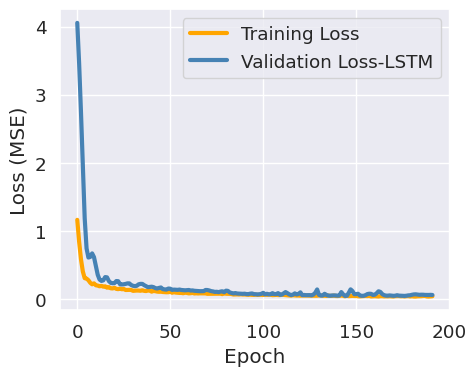

In [237]:
# Plot training & validation loss
# plt.style.use('seaborn')
# plt.figure(figsize=(7,5))
sns.set(font_scale=1.2)

plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='Training Loss', linewidth=3, color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss-LSTM', linewidth=3, color='steelblue')
# plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.tight_layout()
plt.savefig('Bidirection on GHGE_validation_loss.png', dpi = 1000, bbox_inches='tight')
plt.show()

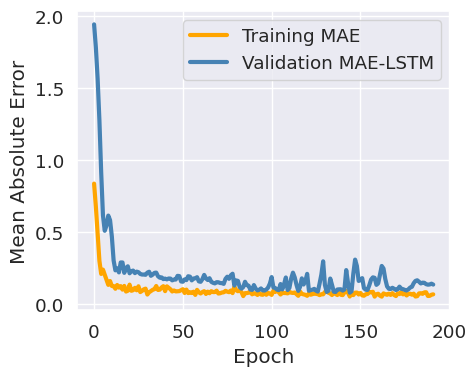

In [238]:
# Plot training & validation MAE
# plt.style.use('seaborn')
# plt.figure(figsize=(7,5))
sns.set(font_scale=1.2)

plt.figure(figsize=(5,4))
plt.plot(history.history['mae'], label='Training MAE', linewidth=3, color='orange')
plt.plot(history.history['val_mae'], label='Validation MAE-LSTM', linewidth=3, color='steelblue')
# plt.title('Model MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.tight_layout()
plt.savefig('LSTM_MAE_loss-OVERWEIGHT.png', dpi = 1000, bbox_inches='tight')
plt.show()

graphs for HEALTH INDICATORS


In [239]:
# bag1= df['Life expectancy ']
# plt.figure(1)
# # plt.style.use('seaborn')
# plt.figure(figsize=(7,5))
# sns.set(font_scale=1.2)
# plt.plot(bag1[:53],'--', color='black',markersize=12, linewidth=3)
# plt.plot(df[53:].index, y_test_unscaled,'-',color='orange',markersize=12, linewidth=3)
# plt.plot(df[53:].index,y_pred,'-', color='steelblue', markersize=12, linewidth=3)
# # plt.title('Measured against model data')
# plt.xlabel('Time (years)')
# plt.ylabel('Life expectancy, yrs ')

# # plt.ylim(70, 80)
# plt.legend(['Life expectancy(train set)', 'Life expectancy(test set)','LSTM model prediction'  ])

# x = [ 0, 10,20,30,40,50,61]

# labels = [1961, 1970, 1980, 1990, 2000,2010, 2021]
# plt.xticks(x, labels, rotation='horizontal')
# # plt.savefig("Agricultural water_BiLSTM.png", dpi = 1000, bbox_inches='tight')

In [240]:
# bag2= df['Obese']
# plt.figure(1)
# # plt.style.use('seaborn')
# plt.figure(figsize=(7,5))
# sns.set(font_scale=1.2)
# plt.plot(bag2[:53],'--', color='black',markersize=12, linewidth=3)
# plt.plot(df[53:].index, y_test_unscaled,'-',color='orange',markersize=12, linewidth=3)
# plt.plot(df[53:].index,y_pred,'-', color='steelblue', markersize=12, linewidth=3)
# # plt.title('Measured against model data')
# plt.xlabel('Time (years)')
# plt.ylabel('Share of obesity, % ')
# # plt.legend(['Share of life Expectancy','Lasso Model prediction ' ])
# # plt.ylim(70, 80)
# plt.legend(['Share of obesity(train set)', 'Share of obesity(test set)','LSTM model prediction'  ])


# x = [ 0, 10,20,30,40,50,61]

# labels = [1961, 1970, 1980, 1990, 2000,2010, 2021]
# plt.xticks(x, labels, rotation='horizontal')
# # plt.savefig("Agricultural water_BiLSTM.png", dpi = 1000, bbox_inches='tight')

([<matplotlib.axis.XTick at 0x78ae456f9900>,
 [Text(0, 0, '1961'),
  Text(10, 0, '1970'),
  Text(20, 0, '1980'),
  Text(30, 0, '1990'),
  Text(40, 0, '2000'),
  Text(50, 0, '2010'),
  Text(61, 0, '2021')])

<Figure size 640x480 with 0 Axes>

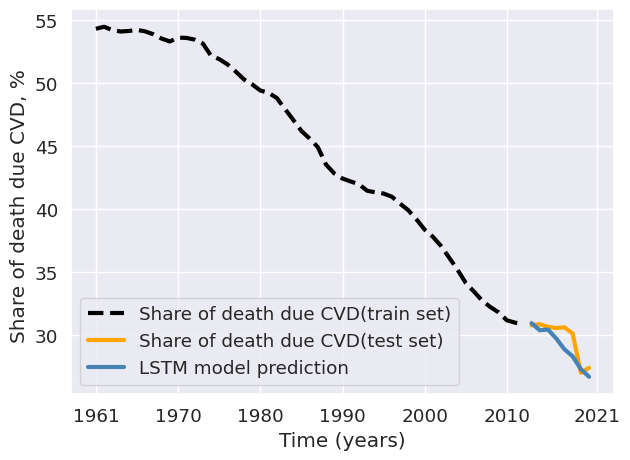

In [241]:
bag3= df['Death-NCD ']
plt.figure(1)
# plt.style.use('seaborn')
plt.figure(figsize=(7,5))
sns.set(font_scale=1.2)
plt.plot(bag3[:53],'--', color='black',markersize=12, linewidth=3)
plt.plot(df[53:].index, y_test_unscaled,'-',color='orange',markersize=12, linewidth=3)
plt.plot(df[53:].index,y_pred,'-', color='steelblue', markersize=12, linewidth=3)
# plt.title('Measured against model data')
plt.xlabel('Time (years)')
plt.ylabel('Share of death due CVD, % ')
# plt.legend(['Share of life Expectancy','Lasso Model prediction ' ])
# plt.ylim(70, 80)
plt.legend(['Share of death due CVD(train set)', 'Share of death due CVD(test set)','LSTM model prediction'  ])


x = [ 0, 10,20,30,40,50,61]

labels = [1961, 1970, 1980, 1990, 2000,2010, 2021]
plt.xticks(x, labels, rotation='horizontal')
# plt.savefig("Agricultural water_BiLSTM.png", dpi = 1000, bbox_inches='tight')